# use this notebook to view current .h5 file format for beamtime with BBox

# Fix handmade features, remove copper dependency

# add motor coordinate calculations from simple_ROI_2018 and.py files

In [1]:
import beamtime_config_2018
# import ROI_Finder_2018
from beamtime_config_2018 import *
# from ROI_Finder_2018 import *
%matplotlib inline

# CHECK PATH TO BEAMTIME DATA

In [18]:
#for beamtime enable following path and disable above
# base_file_path='/home/beams/USERBNP/arshad/XRF_Data/'
base_file_path='/home/beams/USERBNP/arshad/Practice_h5/'

In [3]:
class beamtime_XRF_image:
    
    def __init__(self, xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False):
        self.xrf_filename =xrf_filename
        self.BASE_PATCH_WIDTH=BASE_PATCH_WIDTH
        
        
        
    def load_xrf_data(self, hdf5_string = 'MAPS'):
#         global d_Cu, d_Zn, d_Ca, d_K, d_P, d_S,d_Fe, d_Ni, d_TFY
    
#         norm_ch = NORM_CH # 2018 value
        norm_ch = 'US_IC'
        value_offset=VALUE_OFFSET
        xrfdata = collections.defaultdict(list)

        with h5py.File(self.xrf_filename, 'r') as dat:
            groups= list(dat.keys())
#             print('groups', groups)
            maps= list(dat['MAPS'].keys())
            print('maps', maps)
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
            
            print('chs:', chs)
            
            self.int_spec=dat['MAPS/int_spec'][:].astype(int).tolist()
            self.energy=dat['MAPS/energy'][:].astype(int).tolist()
            
            self.mca_arr=dat['MAPS/mca_arr'][:].astype(int).tolist()
            self.scan_time_stamp=dat['MAPS/scan_time_stamp']
#             print(self.scan_time_stamp)
            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            print('scaler_names:', scaler_names)
            scaler_val = dat['MAPS/scalers'][:]
#             print(scaler_val)
            norm = scaler_val[scaler_names.index(norm_ch)]
#             print('norm:', norm)
            for e in chs:
                chidx = chs.index(e)
                xrfdata[e].append(xrf[chidx]/norm)
            xrfdata['scan_num'].append(self.xrf_filename)

            hdf5_string = hdf5_string

            xrfdata['x_axis'].append(dat[hdf5_string + '/x_axis'][:])
            xrfdata['y_axis'].append(dat[hdf5_string + '/y_axis'][:])

        #         xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
        #         xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
        xrfdata = pd.DataFrame(xrfdata)
        #     print(xrfdata)

        elms=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','Total_Fluorescence_Yield']#Default elms
        for i, row in xrfdata.iterrows():
                sc = row['scan_num'][0:row['scan_num'].index('.')]
                for e in elms:
                    d = row[e]

                    d[np.isnan(d) | np.isinf(d)] = 0
                    norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                    ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)
                    if e == 'Cu':
                        self.d_Cu=d
                        self.norm_d_Cu=norm_d
                        self.x_Cu,self.y_Cu=row['x_axis'], row['y_axis']
                    if e == 'Zn':
                        self.d_Zn=d
                        self.norm_d_Zn=norm_d
                        self.x_Zn,self.y_Zn=row['x_axis'], row['y_axis']
                    if e == 'Ca':
                        self.d_Ca=d
                        self.norm_d_Ca=norm_d
                        self.x_Ca,self.y_Ca=row['x_axis'], row['y_axis']
                    if e == 'K':
                        self.d_K=d
                        self.norm_d_K=norm_d
                        self.x_K,self.y_K=row['x_axis'], row['y_axis']
                    if e == 'P':
                        self.d_P=d
                        self.norm_d_P=norm_d
                        self.x_P,self.y_P=row['x_axis'], row['y_axis']
                    if e == 'S':
                        self.d_S=d
                        self.norm_d_S=norm_d
                        self.x_S,self.y_S=row['x_axis'], row['y_axis']

                    if e == 'Fe':
                        self.d_Fe=d
                        self.norm_d_Fe=norm_d
                        self.x_Fe,self.y_Fe=row['x_axis'], row['y_axis']

                    if e == 'Ni':
                        self.d_Ni=d
                        self.norm_d_Ni=norm_d
                        self.x_Ni,self.y_Ni=row['x_axis'], row['y_axis']

                    if e == 'Total_Fluorescence_Yield':
                        self.d_TFY=d
                        self.norm_d_TFY=norm_d
                        self.x_TFY,self.y_TFY=row['x_axis'], row['y_axis']
#             print('Image shape: ',d.shape)
            
        
        #motor coordinate, steps, resolution
        
        self.x_res=self.x_TFY[1]-self.x_TFY[0]
        self.y_res=self.y_TFY[1]-self.y_TFY[0]
        self.avg_res=(self.x_res+self.y_res)/2
        self.x_origin=self.x_TFY[0]
        self.y_origin=self.y_TFY[0]
        
        
        #debug info
        print('x_res:',self.x_res)
        print('y_res:',self.y_res)
        print('avg_res:',self.avg_res)
        
        print('x_origin:',self.x_origin)
        print('y_origin:',self.y_origin)
        
                    
    def add_noise(self, noise='none'):
        self.noise=noise
        if self.noise == 'normal':
            np.random.seed(0)
            self.normal_noise=abs(np.random.normal(0, 1, self.d_Cu.shape))
            self.d_Cu = self.d_Cu*(1+self.normal_noise) 
            self.d_Zn = self.d_Zn*(1+self.normal_noise)
            self.d_Ca = self.d_Ca*(1+self.normal_noise)
            self.d_K = self.d_K*(1+self.normal_noise)
            self.d_P = self.d_P*(1+self.normal_noise)
            self.d_S = self.d_S*(1+self.normal_noise)
            self.d_Fe = self.d_Fe*(1+self.normal_noise)
            self.d_Ni = self.d_Ni*(1+self.normal_noise)
            self.d_TFY = self.d_TFY*(1+self.normal_noise)
            
        elif self.noise == 'poisson':
            np.random.seed(0)
            self.poisson_noise=abs(np.random.poisson(1000, self.d_Cu.shape))
            self.d_Cu = self.d_Cu*(1+self.poisson_noise) 
            self.d_Zn = self.d_Zn*(1+self.poisson_noise)
            self.d_Ca = self.d_Ca*(1+self.poisson_noise)
            self.d_K = self.d_K*(1+self.poisson_noise)
            self.d_P = self.d_P*(1+self.poisson_noise)
            self.d_S = self.d_S*(1+self.poisson_noise)
            self.d_Fe = self.d_Fe*(1+self.poisson_noise)
            self.d_Ni = self.d_Ni*(1+self.poisson_noise)
            self.d_TFY = self.d_TFY*(1+self.poisson_noise)


        
    
    
    def binary_conversion(self, e='Cu'):
        #choose elemental channel for conversion
        
        if e == 'Cu':
            data_original = self.d_Cu
            
        if e == 'Zn':
            data_original = self.d_Zn
            
        if e == 'Ca':
            data_original = self.d_Ca
            
        if e == 'K':
            data_original = self.d_K
            
        if e == 'P':
            data_original = self.d_P
            
        if e == 'S':
            data_original = self.d_S
            

        if e == 'Fe':
            data_original = self.d_Fe
            

        if e == 'Ni':
            data_original = self.d_Ni
            
        if e == 'Total_Fluorescence_Yield':
            data_original = self.d_TFY
            
#         data_original=d_Cu
        data=data_original
        data = ndimage.median_filter(data, size=3)


        thresh = 1.25*threshold_otsu(data)
        binary = data < thresh
        binary = binary^1


        binary_eroded=ndimage.binary_erosion(binary).astype(binary.dtype)
        binary_dilated=ndimage.binary_dilation(binary).astype(binary.dtype)
        self.binary_ero_dil=ndimage.binary_dilation(binary_eroded).astype(binary_eroded.dtype)
        
        self.labeled_array, self.num_features = label(self.binary_ero_dil)
        
    def extract_cells(self):
        self.regions = measure.regionprops(self.labeled_array)    
        # print(len(regions))

        self.cell_list = []
        self.center_list = []
        self.Patches_Cu = []
        self.Patches_Zn = []
        self.Patches_Ca = []
        self.Patches_K = []
        self.Patches_P = []
        self.Patches_S = []
        self.Patches_Fe = []
        self.Patches_Ni = []
        self.Patches_TFY= []
        self.binary_img=[]
        self.region_vals=[]
        self.features_list = []
        self.center_coords=[]
        self.XRF_track_files=[]
        
        #motor coordinate stuff
        
        self.x_res_list= []
        self.y_res_list= []
        self.avg_res_list= []
        self.x_origin_list= []
        self.y_origin_list= []
        
        self.x_motor_center_list= []
        self.y_motor_center_list= []


        for idx in range(len(self.regions)):
            
            #append motor coordinate stuff for each region so they can be retrived later via pandas
            
            self.x_res_list.append(self.x_res)
            self.y_res_list.append(self.y_res) 
            self.avg_res_list.append(self.avg_res)
            self.x_origin_list.append(self.x_origin)
            self.y_origin_list.append(self.y_origin)
            
            #cell extraction begins here
            
            self.cell_val_bin=self.regions[idx].image
            
            self.center_coords.append(self.regions[idx].centroid)
            self.XRF_track_files.append(self.xrf_filename)

            self.region_vals.append(self.cell_val_bin)
            self.padded_cell = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.cell_list.append(self.padded_cell)
            self.center_list.append([math.floor(self.regions[idx].centroid[0]), math.floor(self.regions[idx].centroid[1])])
            #center list is given in (y,x)
            #calculate motor centers here
            
            self.x_motor_center_list.append(self.x_origin_list[idx] + self.x_res_list[idx]*self.center_list[idx][1])
            self.y_motor_center_list.append(self.y_origin_list[idx] + self.y_res_list[idx]*self.center_list[idx][0])
            
            
        #     regions[idx].bbox

            self.cell_Cu = self.d_Cu[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Zn = self.d_Zn[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ca = self.d_Ca[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_K = self.d_K[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_P = self.d_P[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_S = self.d_S[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Fe = self.d_Fe[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ni = self.d_Ni[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_TFY = self.d_TFY[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]

            self.padded_bin = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Cu = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Zn = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ca = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_K = np.pad(self.cell_K, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_P = np.pad(self.cell_P, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_S = np.pad(self.cell_S, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Fe = np.pad(self.cell_Fe, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ni = np.pad(self.cell_Ni, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_TFY = np.pad(self.cell_TFY, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))

            self.binary_img.append(self.padded_bin)
            self.Patches_Cu.append(self.padded_Cu)
            self.Patches_Zn.append(self.padded_Zn)
            self.Patches_Ca.append(self.padded_Ca)
            self.Patches_K.append(self.padded_K)
            self.Patches_P.append(self.padded_P)
            self.Patches_S.append(self.padded_S)
            self.Patches_Fe.append(self.padded_Fe)
            self.Patches_Ni.append(self.padded_Ni)
            self.Patches_TFY.append(self.padded_TFY)


            # define feature vector using averages
        #     x = np.asarray([regions[idx].area, 
        #      regions[idx].eccentricity, 
        #      regions[idx].equivalent_diameter, 
        #      regions[idx].major_axis_length,
        #      regions[idx].minor_axis_length,
        #      regions[idx].perimeter,
        #      np.average(Patches_K[idx]),
        #      np.average(Patches_K[idx])/np.average(Patches_P[idx]),
        #      np.average(Patches_Ni[idx]),
        #      np.average(Patches_Ni[idx])/np.average(Patches_P[idx]),
        #     np.average(Patches_Ni[idx])/np.average(Patches_K[idx]),
        #     np.average(Patches_Cu[idx])/np.average(Patches_K[idx]),
        #     ])

            # define feature vector using averages
            self.avg_res
            
            self.x = np.asarray([self.avg_res*self.avg_res*self.regions[idx].area, 
             self.regions[idx].eccentricity, 
             self.avg_res*self.regions[idx].equivalent_diameter, 
             self.avg_res*self.regions[idx].major_axis_length,
             self.avg_res*self.regions[idx].minor_axis_length,
             self.avg_res*self.regions[idx].perimeter,
             np.amax(self.Patches_K[idx]),
             np.amax(self.Patches_P[idx]),
             np.amax(self.Patches_Ni[idx]),
             np.amax(self.Patches_Zn[idx]),
            np.amax(self.Patches_Fe[idx]),
            np.amax(self.Patches_Cu[idx]),
            np.amax(self.Patches_TFY[idx]-self.Patches_K[idx]-self.Patches_P[idx]-self.Patches_Ni[idx]-self.Patches_Zn[idx]-self.Patches_Fe[idx]-self.Patches_Cu[idx]),
            np.unique(x.region_vals[idx], return_counts=True)[1][1] # returns the number of true (1's) values in the identified region
            ])

            self.features_list.append(self.x)
        self.features=np.asarray(self.features_list)



In [4]:
def calc_SNR(img, seg_img, labels = (0,1), mask_ratio = None):
    """
    SNR =  1     /  s*sqrt(std0^^2 + std1^^2)  
    where s = 1 / (mu1 - mu0)  
    mu1, std1 and mu0, std0 are the mean / std values for each of the segmented regions respectively (pix value = 1) and (pix value = 0).  
    seg_img is used as mask to determine stats in each region.  
    Parameters
    ----------
    img : np.array  
        raw input image (2D or 3D)  

    seg_img : np.array  
        segmentation map (2D or 3D)  

    labels : tuple  
        an ordered list of two label values in the image. The high value is interpreted as the signal and low value is the background.  

    mask_ratio : float or None
        If not None, a float in (0,1). The data are cropped such that the voxels / pixels outside the circular mask are ignored.  
    Returns
    -------
    float
        SNR of img w.r.t seg_img  
    """
    eps = 1.0e-12
    # handle circular mask  
    if mask_ratio is not None:
        crop_val = int(img.shape[-1]*0.5*(1 - mask_ratio/np.sqrt(2)))
        crop_slice = slice(crop_val, -crop_val)    

        if img.ndim == 2: # 2D image
            img = img[crop_slice, crop_slice]
            seg_img = seg_img[crop_slice, crop_slice]
        elif img.ndim == 3: # 3D image
            vcrop = int(img.shape[0]*(1-mask_ratio))
            vcrop_slice = slice(vcrop, -vcrop)
            img = img[vcrop_slice, crop_slice, crop_slice]
            seg_img = seg_img[vcrop_slice, crop_slice, crop_slice]

    pix_1 = img[seg_img == labels[1]]
    pix_0 = img[seg_img == labels[0]]

    if np.any(pix_1) and np.any(pix_0):
        mu1 = np.mean(pix_1)
        mu0 = np.mean(pix_0)
        s = abs(1/(mu1 - mu0 + eps))
        std1 = np.std(pix_1)
        std0 = np.std(pix_0)
        std = np.sqrt(0.5*(std1**2 + std0**2))
        std = s*std
        return 1/(std + eps)
    else:
        return 1/(np.std(img) + eps)

In [5]:
x= beamtime_XRF_image(xrf_filename = '/data02/AZC/beamtime_data/bnp_fly0124.mda.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='MAPS')
# x.add_noise(noise=noise_type)

x.binary_conversion(e='Zn')
x.extract_cells()
X_bin1=x.binary_img  


X_Cu1=x.Patches_Cu
X_Zn1=x.Patches_Zn
X_Ca1=x.Patches_Ca
X_K1=x.Patches_K
X_P1=x.Patches_P
X_S1=x.Patches_S
X_Fe1=x.Patches_Fe
X_Ni1=x.Patches_Ni
X_TFY1=x.Patches_TFY

X_x_res1=x.x_res_list
X_y_res1=x.y_res_list
X_avg_res1=x.avg_res_list
X_x_origin1=x.x_origin_list
X_y_origin1=x.y_origin_list

X_x_motor1=x.x_motor_center_list
X_y_motor1=x.y_motor_center_list


SNR_X1=calc_SNR(x.d_Zn, x.binary_ero_dil)

X1=x.features

X_centers1=x.center_coords
X_xrf_track_file1=x.XRF_track_files

X1.shape

maps ['Quantification', 'Scalers', 'Scan', 'Spectra', 'XRF_Analyzed', 'XRF_roi', 'XRF_roi_plus', 'XRF_roi_plus_quant', 'XRF_roi_quant', 'channel_names', 'channel_units', 'ds_amp', 'energy', 'energy_calib', 'extra_pvs', 'int_spec', 'make_maps_conf', 'max_chan_spec', 'mca_arr', 'scaler_names', 'scaler_units', 'scalers', 'scan_time_stamp', 'us_amp', 'version', 'x_axis', 'y_axis']
chs: ['Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Si_Cl', 'Total_Fluorescence_Yield', 'Si_Si', 'Cl_Cl', 'COHERENT_SCT_AMPLITUDE', 'COMPTON_AMPLITUDE', 'Num_Iter', 'Fit_Residual', 'Sum_Elastic_Inelastic']
scaler_names: ['CFG_2', 'CFG_3', 'CFG_4', 'CFG_5', 'DS_IC', 'Dead_Time', 'ELT', 'ERT', 'H_dpc_cfg', 'ICR1', 'ICR2', 'ICR3', 'ICR4', 'INCNT', 'OCR1', 'OCR2', 'OCR3', 'OCR4', 'OUTCNT', 'US_IC', 'V_dpc_cfg', 'abs_cfg', 'abs_ic', 'dia1_dpc_cfg', 'dia2_dpc_cfg']
x_res: 1.5
y_res: 1.512146
avg_res: 1.506072998046875
x_origin: 158.38527
y_origin: -836.84015


(1, 14)

In [17]:
# X_x_origin=x.x_origin_list
# X_y_origin=x.y_origin_list
# X_x_res=x.x_res_list
# X_y_res=x.y_res_list
# print('XRF image resolution x:',x.x_res)
# print('XRF image resolution y:',x.y_res)
# print('x grid')
# print(x.x_TFY)

# print('y grid')
# print(x.y_TFY)


# idx=0
# #center list is given in (y,x)
# x_motor_center = x.x_origin_list[idx] + x.x_res_list[idx]*x.center_list[idx][1]
# y_motor_center = x.y_origin_list[idx] + x.y_res_list[idx]*x.center_list[idx][0]
# print('XRF image shape:',x.d_TFY.shape)

In [7]:
x= beamtime_XRF_image(xrf_filename = '/data02/AZC/beamtime_data/bnp_fly0124.mda.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='MAPS')
# x.add_noise(noise=noise_type)

x.binary_conversion(e='Zn')
x.extract_cells()
X_bin2=x.binary_img  


X_Cu2=x.Patches_Cu
X_Zn2=x.Patches_Zn
X_Ca2=x.Patches_Ca
X_K2=x.Patches_K
X_P2=x.Patches_P
X_S2=x.Patches_S
X_Fe2=x.Patches_Fe
X_Ni2=x.Patches_Ni
X_TFY2=x.Patches_TFY

X_x_res2=x.x_res_list
X_y_res2=x.y_res_list
X_avg_res2=x.avg_res_list
X_x_origin2=x.x_origin_list
X_y_origin2=x.y_origin_list

X_x_motor2=x.x_motor_center_list
X_y_motor2=x.y_motor_center_list




SNR_X2=calc_SNR(x.d_Zn, x.binary_ero_dil)

X2=x.features

X_centers2=x.center_coords
X_xrf_track_file2=x.XRF_track_files

X2.shape

maps ['Quantification', 'Scalers', 'Scan', 'Spectra', 'XRF_Analyzed', 'XRF_roi', 'XRF_roi_plus', 'XRF_roi_plus_quant', 'XRF_roi_quant', 'channel_names', 'channel_units', 'ds_amp', 'energy', 'energy_calib', 'extra_pvs', 'int_spec', 'make_maps_conf', 'max_chan_spec', 'mca_arr', 'scaler_names', 'scaler_units', 'scalers', 'scan_time_stamp', 'us_amp', 'version', 'x_axis', 'y_axis']
chs: ['Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Si_Cl', 'Total_Fluorescence_Yield', 'Si_Si', 'Cl_Cl', 'COHERENT_SCT_AMPLITUDE', 'COMPTON_AMPLITUDE', 'Num_Iter', 'Fit_Residual', 'Sum_Elastic_Inelastic']
scaler_names: ['CFG_2', 'CFG_3', 'CFG_4', 'CFG_5', 'DS_IC', 'Dead_Time', 'ELT', 'ERT', 'H_dpc_cfg', 'ICR1', 'ICR2', 'ICR3', 'ICR4', 'INCNT', 'OCR1', 'OCR2', 'OCR3', 'OCR4', 'OUTCNT', 'US_IC', 'V_dpc_cfg', 'abs_cfg', 'abs_ic', 'dia1_dpc_cfg', 'dia2_dpc_cfg']
x_res: 1.5
y_res: 1.512146
avg_res: 1.506072998046875
x_origin: 158.38527
y_origin: -836.84015


(1, 14)

In [8]:
X=np.concatenate((X1,X2))
X_bin=np.concatenate((X_bin1,X_bin2))
X_Cu=np.concatenate((X_Cu1,X_Cu2))
X_Zn=np.concatenate((X_Zn1,X_Zn2))
X_Ca=np.concatenate((X_Ca1,X_Ca2))
X_K=np.concatenate((X_K1,X_K2))
X_P=np.concatenate((X_P1,X_P2))
X_S=np.concatenate((X_S1,X_S2))
X_Fe=np.concatenate((X_Fe1,X_Fe2))
X_Ni=np.concatenate((X_Ni1,X_Ni2))
X_TFY=np.concatenate((X_TFY1,X_TFY2))

X_x_res=np.concatenate((X_x_res1,X_x_res2))
X_y_res=np.concatenate((X_y_res1,X_y_res2))
X_avg_res=np.concatenate((X_avg_res1,X_avg_res2))

X_x_origin=np.concatenate((X_x_origin1,X_x_origin2))
X_y_origin=np.concatenate((X_y_origin1,X_y_origin2))

X_x_motor=np.concatenate((X_x_motor1,X_x_motor2))
X_y_motor=np.concatenate((X_y_motor1,X_y_motor2))



SNR=np.array([SNR_X1,SNR_X2])
SNR_Df = pd.DataFrame()
SNR_Df['SNR']=SNR
# print(SNR_Df.to_string())

X_centers=np.concatenate((X_centers1,X_centers2))

X_xrf_track_files=np.concatenate((X_xrf_track_file1,X_xrf_track_file2))


print('Total extracted cells, features:', X.shape)
print('Total extracted cell, cell size:', X_bin.shape)

principalDf = pd.DataFrame(
             columns = ['Pixel_count', 'area'])

principalDf['area'] = X[:,0]
principalDf['eccentricity'] = X[:,1]
principalDf['equivalent_diameter'] = X[:,2]
principalDf['major_axis_length'] = X[:,3]
principalDf['minor_axis_length'] = X[:,4]
principalDf['perimeter'] = X[:,5]
principalDf['K'] = X[:,6]
principalDf['P'] = X[:,7]
principalDf['Ni'] = X[:,8]
principalDf['Zn'] = X[:,9]
principalDf['Fe'] = X[:,10]
principalDf['Cu'] = X[:,11]
principalDf['BFY'] = X[:,12]
principalDf['Pixel_count'] = X[:,13].astype(int)
# display(principalDf)


#add res and origins to dataframe here

principalDf['x_res'] = X_x_res
principalDf['y_res'] = X_y_res
principalDf['avg_res'] = X_avg_res
principalDf['x_origin'] = X_x_origin
principalDf['y_origin'] = X_y_origin
principalDf['x_motor'] = X_x_motor
principalDf['y_motor'] = X_y_motor




data_dict = {'X':X, 'X_bin':X_bin, 'X_Cu':X_Cu, 'X_Zn':X_Zn, 'X_Ca':X_Ca, 'X_K':X_K,
                 'X_P':X_P,'X_S':X_S,'X_Fe':X_Fe,'X_Ni':X_Ni, 'X_TFY':X_TFY, 'principalDf':principalDf,
                'X_centers':X_centers,'X_xrf_track_files':X_xrf_track_files, 
                 'x_res':X_x_res, 'y_res':X_y_res,'avg_res':X_avg_res,'x_origin':X_x_origin,'y_origin':X_y_origin,
                 'x_motor':X_x_motor,'y_motor':X_y_motor,
                'BASE_PATCH_WIDTH':x.BASE_PATCH_WIDTH}
    

Total extracted cells, features: (2, 14)
Total extracted cell, cell size: (2, 32, 32)


In [9]:
XRF_data = data_dict

X=XRF_data['X']
X_bin=XRF_data['X_bin']
X_Cu=XRF_data['X_Cu']
X_Zn=XRF_data['X_Zn']
X_Ca=XRF_data['X_Ca']
X_K=XRF_data['X_K']
X_P=XRF_data['X_P']
X_S=XRF_data['X_S']
X_Fe=XRF_data['X_Fe']
X_Ni=XRF_data['X_Ni']
X_TFY=XRF_data['X_TFY']
principalDf=XRF_data['principalDf']
X_centers=XRF_data['X_centers']
X_xrf_track_files=XRF_data['X_xrf_track_files']
X_x_res = XRF_data['x_res']
X_y_res = XRF_data['y_res']
X_avg_res = XRF_data['avg_res']

X_x_origin = XRF_data['x_origin']
X_y_origin = XRF_data['y_origin']

BASE_PATCH_WIDTH = XRF_data['BASE_PATCH_WIDTH']

# calculate motor coordinates
# centers fro regionprops are in (y,x)

center_offset=0

# X_x_motor = X_x_origin+X_x_res*X_centers[:,1] + center_offset
# X_y_motor = X_y_origin+X_y_res*X_centers[:,0] + center_offset


# get the annotated data so remove if not annotated
# secondaryDf=principalDf[principalDf['KO_label'] != 'not_annotated' ]
secondaryDf=principalDf

# remove additional artifacts that do not contain 8 pixels, currently set to 3
secondaryDf=secondaryDf[secondaryDf['Pixel_count'] >3]

#keep track of the original indices after removing artifacts
secondaryDf['original index'] = secondaryDf.index.to_numpy()
secondaryDf.reset_index(drop=True, inplace=True)

print('Bounding box width and height (pixels):' , BASE_PATCH_WIDTH)
 

Bounding box width and height (pixels): 32


In [10]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(secondaryDf)

In [11]:
# X=np.concatenate((X1,X2,X3,X4,X5,X6,X7,X8,X9,X10))
# X_bin=np.concatenate((X_bin1,X_bin2,X_bin3,X_bin4,X_bin5,X_bin6,X_bin7,X_bin8,X_bin9,X_bin10))
# X_Cu=np.concatenate((X_Cu1,X_Cu2,X_Cu3,X_Cu4,X_Cu5,X_Cu6,X_Cu7,X_Cu8,X_Cu9,X_Cu10))
# X_Zn=np.concatenate((X_Zn1,X_Zn2,X_Zn3,X_Zn4,X_Zn5,X_Zn6,X_Zn7,X_Zn8,X_Zn9,X_Zn10))
# X_Ca=np.concatenate((X_Ca1,X_Ca2,X_Ca3,X_Ca4,X_Ca5,X_Ca6,X_Ca7,X_Ca8,X_Ca9,X_Ca10))
# X_K=np.concatenate((X_K1,X_K2,X_K3,X_K4,X_K5,X_K6,X_K7,X_K8,X_K9,X_K10))
# X_P=np.concatenate((X_P1,X_P2,X_P3,X_P4,X_P5,X_P6,X_P7,X_P8,X_P9,X_P10))
# X_S=np.concatenate((X_S1,X_S2,X_S3,X_S4,X_S5,X_S6,X_S7,X_S8,X_S9,X_S10))
# X_Fe=np.concatenate((X_Fe1,X_Fe2,X_Fe3,X_Fe4,X_Fe5,X_Fe6,X_Fe7,X_Fe8,X_Fe9,X_Fe10))
# X_Ni=np.concatenate((X_Ni1,X_Ni2,X_Ni3,X_Ni4,X_Ni5,X_Ni6,X_Ni7,X_Ni8,X_Ni9,X_Ni10))
# X_TFY=np.concatenate((X_TFY1,X_TFY2,X_TFY3,X_TFY4,X_TFY5,X_TFY6,X_TFY7,X_TFY8,X_TFY9,X_TFY10))

# SNR=np.array([SNR_X1,SNR_X2,SNR_X3,SNR_X4,SNR_X5,SNR_X6,SNR_X7,SNR_X8,SNR_X9,SNR_X10])
# SNR_Df = pd.DataFrame()
# SNR_Df['SNR']=SNR
# print(SNR_Df.to_string())
# print('Total extracted cells, features:', X.shape)
# print('Total extracted cell, cell size:', X_bin.shape)


# X_centers=np.concatenate((X_centers1,X_centers2,X_centers3,X_centers4,X_centers5,X_centers6,X_centers7,X_centers8,X_centers9,X_centers10))

# X_xrf_track_files=np.concatenate((X_xrf_track_file1,X_xrf_track_file2,X_xrf_track_file3,X_xrf_track_file4,X_xrf_track_file5,
#                   X_xrf_track_file6,X_xrf_track_file7,X_xrf_track_file8,X_xrf_track_file9,X_xrf_track_file10))


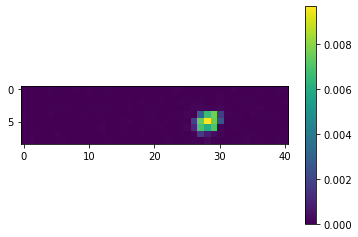

In [12]:
plt.imshow(x.d_Zn)
plt.colorbar()

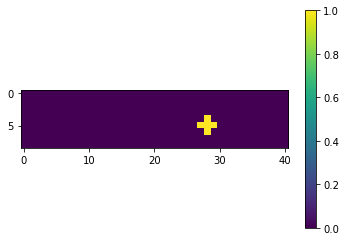

In [13]:
plt.imshow(x.binary_ero_dil)
plt.colorbar()

In [19]:
linethresh_val=0.00001
resolution=DEFAULT_RESOLUTION_CELL

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
%matplotlib inline


def viewer(idx):

    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    im1 = ax1.imshow(X_bin[idx].T, interpolation='none')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*resolution, "m", color='white', length_fraction=0.10, box_alpha=0.10)
    ax1.add_artist(scalebar_master)
    
    

    ax2 = fig.add_subplot(522)
    ax2.set_title('Cu')
    im2 = ax2.imshow(X_Cu[idx].T, interpolation='none', vmax=0.003087)
#     im2 = ax2.imshow(X_Cu[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');


    ax3 = fig.add_subplot(523)
    ax3.set_title('Zn')
    im3 = ax3.imshow(X_Zn[idx].T, interpolation='none', vmax=0.00318)
#     im3 = ax3.imshow(X_Zn[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical');

    ax4 = fig.add_subplot(524)
    ax4.set_title('Ca')
    im4 = ax4.imshow(X_Ca[idx].T, interpolation='none', vmax=0.00174)
#     im4 = ax4.imshow(X_Ca[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val) )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical');


    ax5 = fig.add_subplot(525)
    ax5.set_title('K')
    im5 = ax5.imshow(X_K[idx].T, interpolation='none',vmax=0.000584)
#     im5 = ax5.imshow(X_K[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical');

    ax6 = fig.add_subplot(526)
    ax6.set_title('P')
    im6 = ax6.imshow(X_P[idx].T, interpolation='none', vmax=0.000164)
#     im6 = ax6.imshow(X_P[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical');

    ax7 = fig.add_subplot(527)
    ax7.set_title('S')
    im7 = ax7.imshow(X_S[idx].T, interpolation='none', vmax=0.000122)
#     im7 = ax7.imshow(X_S[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax7)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im7, cax=cax, orientation='vertical');

    ax8 = fig.add_subplot(528)
    ax8.set_title('Ni')
    im8 = ax8.imshow(X_Ni[idx].T, interpolation='none', vmax=0.000093)
#     im8 = ax8.imshow(X_Ni[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax8)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im8, cax=cax, orientation='vertical');

    ax9 = fig.add_subplot(529)
    ax9.set_title('Fe')
    im9 = ax9.imshow(X_Fe[idx].T, interpolation='none', vmax=0.000139)
#     im9 = ax9.imshow(X_Fe[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax9)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im9, cax=cax, orientation='vertical');

    ax10 = fig.add_subplot(5,2,10)
    ax10.set_title('TFY')
    im10 = ax10.imshow(X_TFY[idx].T, interpolation='none', vmax=0.029495)
#     im10 = ax10.imshow(X_TFY[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = 500*linethresh_val))
    divider = make_axes_locatable(ax10)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im10, cax=cax, orientation='vertical');
    
    print('Avg. Cu:',np.average(X_Cu[idx]))
    print('Avg. Zn:',np.average(X_Zn[idx]))
    print('Avg. Ca:',np.average(X_Ca[idx]))
    print('Avg. K:',np.average(X_K[idx]))
    print('Avg. P:',np.average(X_P[idx]))
    print('Avg. S:',np.average(X_S[idx]))
    print('Avg. Fe:',np.average(X_Fe[idx]))
    print('Avg. Ni:',np.average(X_Ni[idx]))
    print('Avg. TFY:',np.average(X_TFY[idx]))

    

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=0, description='idx', max=1), Output()), _dom_classes=('widget-interact'…

In [20]:
selected_elm_channel = 'Zn'
# selected_elm_channel =  'Total_Fluorescence_Yield'

%matplotlib inline

def viewer(idx):
    
    x = beamtime_XRF_image(xrf_filename = X_xrf_track_files[idx],
             BASE_PATCH_WIDTH=32, verbosity=False)
    x.load_xrf_data(hdf5_string='MAPS')
    
    
    if selected_elm_channel == 'Cu':
        d_XRF=x.d_Cu

    if selected_elm_channel == 'Zn':
        d_XRF=x.d_Zn

    if selected_elm_channel == 'Ca':
        d_XRF=x.d_Ca

    if selected_elm_channel == 'K':
        d_XRF=x.d_K

    if selected_elm_channel == 'P':
        d_XRF=dx._P

    if selected_elm_channel == 'S':
        d_XRF=x.d_S

    if selected_elm_channel == 'Fe':
        d_XRF=x.d_Fe

    if selected_elm_channel == 'Ni':
        d_XRF=x.d_Ni

    if selected_elm_channel == 'Total_Fluorescence_Yield':
        d_XRF=x.d_TFY

    
    
    fig, ax = plt.subplots(dpi=150)
    
    img=ax.imshow(d_XRF)
    ax.set_title('Selected Channel: ' + selected_elm_channel)
    fig.colorbar(img, orientation='vertical')
    
    #16 is the halfwidth of the images
    # we get centers from the patches2d data structure, but the bounding box requires corner points
    
    cell_bbox = patches.Rectangle((X_centers[idx][1]-16, X_centers[idx][0]-16), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(cell_bbox)


    # OR PLOT cross-hair to mark location in main image
    ax.plot(X_centers[idx][1], X_centers[idx][0], 'w+', markersize=CROSS_HAIR_SIZE)
    
    print('x_motor:',X_x_motor[idx])
    print('y_motor:',X_y_motor[idx])
    
    

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=0, description='idx', max=1), Output()), _dom_classes=('widget-interact'…